In [1]:
# Step 1: Install FFTW
!apt-get install libfftw3-dev
!apt-get install libfftw3-mpi-dev

# Step 2: Set paths for Dedalus installation
import os
os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"

# Step 3: Install Dedalus using pip
!pip3 install dedalus

#2D Rayleigh-Bernard convection in Boussineq approximation

#Importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import dedalus.public as de
from dedalus.extras import flow_tools
from dedalus.tools import post
import shutil
import random
import time
import h5py
import pathlib
import logging

logger = logging.getLogger('2D RB Convection')

/bin/bash: apt-get: command not found


/bin/bash: apt-get: command not found


  Using cached https://files.pythonhosted.org/packages/6d/89/0f5b60cfd1d8dbe89f1f7293ee388ceef66f537ee8b5988cb6c7a8d35c6b/dedalus-2.2207.tar.gz


    Complete output from command python setup.py egg_info:


    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/private/var/folders/qf/dfz088fn4_g4gpgm95zbg7x8000219/T/pip-build-e6pt52rs/dedalus/setup.py", line 17, in <module>
        from Cython.Build import cythonize
    ModuleNotFoundError: No module named 'Cython'
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /private/var/folders/qf/dfz088fn4_g4gpgm95zbg7x8000219/T/pip-build-e6pt52rs/dedalus/
You are using pip version 9.0.1, however version 22.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


ModuleNotFoundError: No module named 'dedalus'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!rm -rf /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots

In [ ]:
#Defining variables
Lx, d = (16. ,9.)
xres, zres = (128*10,64*10) #Change these to change resolution

#Non-dimensional numbers
Pr = 1
Ra = 1.0e10

In [ ]:
#Defining basis and domains
xbasis = de.Fourier('x',xres,interval=(0,Lx),dealias=3/2)
zbasis = de.Chebyshev('z',zres,interval=(0,d),dealias=3/2)

domain  = de.Domain([xbasis,zbasis],grid_dtype=np.float64)
problem = de.IVP(domain,variables=['T','p','u','w','Tz','uz','wz'])

In [ ]:
#Defining non-dimensional parameters
problem.parameters['Pr'] = Pr
problem.parameters['Ra'] = Ra
problem.parameters['xres'] = xres

#Main Boussineq Rayleigh-Bernard convection equations
problem.add_equation("dt(u) + dx(p) - (dx(dx(u)) + dz(uz)) = - (u * dx(u) + w * uz)")
problem.add_equation("dt(w) + dz(p) - (dx(dx(w)) + dz(wz)) - (Ra / Pr) * T = - (u * dx(w) + w * wz)")
problem.add_equation("dt(T) - (1 / Pr) * (dx(dx(T)) + dz(Tz)) = - (u * dx(T) + w * Tz)")

#Auxillary equations
problem.add_equation("dz(u) - uz = 0")
problem.add_equation("dz(w) - wz = 0")
problem.add_equation("dz(T) - Tz = 0")

#Continuity equation
problem.add_equation("dx(u) + wz = 0")

#Boundary conditions

#Fixed temperature at top boundary
problem.add_bc("right(T) = 0")

#Fixed flux on bottom boundary
problem.add_bc("left(Tz) = -1")

#Standard fluid dynamics boundary conditions
problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(w) = 0")
problem.add_bc("right(w) = 0",condition="(nx != 0)")
problem.add_bc("right(p) = 0",condition="(nx == 0)")

In [ ]:
#Build solver
solver = problem.build_solver(de.timesteppers.RK111) #RK111 = first order runge kutte timestepping method
logger.info('Solver built')

2022-03-23 03:06:06,966 pencil 0/1 INFO :: Building pencil matrix 1/640 (~0%) Elapsed: 0s, Remaining: 48s, Rate: 1.3e+01/s
2022-03-23 03:06:10,406 pencil 0/1 INFO :: Building pencil matrix 64/640 (~10%) Elapsed: 4s, Remaining: 32s, Rate: 1.8e+01/s
2022-03-23 03:06:13,932 pencil 0/1 INFO :: Building pencil matrix 128/640 (~20%) Elapsed: 7s, Remaining: 28s, Rate: 1.8e+01/s
2022-03-23 03:06:16,900 pencil 0/1 INFO :: Building pencil matrix 182/640 (~28%) Elapsed: 10s, Remaining: 25s, Rate: 1.8e+01/s
2022-03-23 03:06:17,447 pencil 0/1 INFO :: Building pencil matrix 192/640 (~30%) Elapsed: 11s, Remaining: 25s, Rate: 1.8e+01/s
2022-03-23 03:06:20,920 pencil 0/1 INFO :: Building pencil matrix 256/640 (~40%) Elapsed: 14s, Remaining: 21s, Rate: 1.8e+01/s
2022-03-23 03:06:24,377 pencil 0/1 INFO :: Building pencil matrix 320/640 (~50%) Elapsed: 17s, Remaining: 17s, Rate: 1.8e+01/s
2022-03-23 03:06:26,928 pencil 0/1 INFO :: Building pencil matrix 367/640 (~57%) Elapsed: 20s, Remaining: 15s, Rate: 1

In [ ]:
#Initial conditions or restart
if not pathlib.Path('restart.h5').exists():

    #Initial conditions
    x, z = domain.all_grids()
    zz,xx  = np.meshgrid(z,x)
    T = solver.state['T']
    Tz = solver.state['Tz']

    #Creating random perturbations
    gshape = domain.dist.grid_layout.global_shape(scales=1)
    slices = domain.dist.grid_layout.slices(scales=1)
    rand   = np.random.RandomState(seed=42)
    noise  = rand.standard_normal(gshape)[slices]
    location_x = random.sample(range(xres), 80)
    location_z = random.sample(range(zres), 80)
    noise      = np.zeros((xres,zres))
    for i in range(40):
        noise =  0.1*np.exp(-(xx-xx[location_x[i],location_z[i]])**2/0.3**2-(zz-0)**2/0.2**2)+noise
    for i in range(40,80):
        noise = -0.1*np.exp(-(xx-xx[location_x[i],location_z[i]])**2/0.3**2-(zz-9)**2/0.2**2)+noise
      

    #Linear background + perturbations damped at walls
    zb,zt = zbasis.interval
    pert = 1e-1 * noise * (zt - z) * (z - zb)
    T['g'] = pert
    T.differentiate('z',out=Tz)

    #Timestepping and output
    dt = 5e-8
    stop_sim_time = 5 #Change this to change total sim time
    fh_mode = 'overwrite'

else:
    #Restart
    write,last_dt = solver.load_state('restart.h5', -1)

    #Timestepping and output
    dt = last_dt
    stop_sim_time = 5e-3
    fh_mode = 'append'

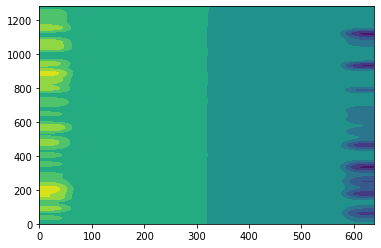

In [ ]:
plt.contourf(noise)

In [ ]:
#Integration parameters
solver.stop_sim_time  = stop_sim_time
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

In [ ]:
#Analysis
shutil.rmtree('/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots', ignore_errors=True)
snapshots = solver.evaluator.add_file_handler('/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots',sim_dt=5e-5,max_writes=200,mode=fh_mode)
snapshots.add_task("integ(T,'x')/xres", layout='g', name='<Tx>')
snapshots.add_task("0.5 * (u ** 2 + w ** 2)", layout='g', name='KE')
snapshots.add_task("sqrt(u ** 2 + w ** 2)", layout='g', name='|uvec|')
snapshots.add_system(solver.state)

In [ ]:
#CFL (don't touch)
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=0.5, max_change=1.5, min_change=1, max_dt=5e-8, threshold=0.05)
CFL.add_velocities(('u', 'w'))

flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
flow.add_property("sqrt(u ** 2 + w ** 2)/Ra", name='Re')

In [ ]:
# Main loop 
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.proceed:
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 100 == 0:
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f minutes' %((end_time-start_time)/60))

2022-03-22 22:54:50,189 2D RB Convection 0/1 INFO :: Starting loop
2022-03-22 22:55:02,407 2D RB Convection 0/1 INFO :: Iteration: 1, Time: 1.000000e-08, dt: 1.000000e-08
2022-03-22 22:57:29,370 2D RB Convection 0/1 INFO :: Iteration: 101, Time: 1.010000e-06, dt: 1.000000e-08
2022-03-22 22:59:53,384 2D RB Convection 0/1 INFO :: Iteration: 201, Time: 2.010000e-06, dt: 1.000000e-08
2022-03-22 23:02:17,575 2D RB Convection 0/1 INFO :: Iteration: 301, Time: 3.010000e-06, dt: 1.000000e-08
2022-03-22 23:04:46,240 2D RB Convection 0/1 INFO :: Iteration: 401, Time: 4.010000e-06, dt: 1.000000e-08
2022-03-22 23:07:09,491 2D RB Convection 0/1 INFO :: Iteration: 501, Time: 5.010000e-06, dt: 1.000000e-08
2022-03-22 23:09:33,422 2D RB Convection 0/1 INFO :: Iteration: 601, Time: 6.010000e-06, dt: 1.000000e-08
2022-03-22 23:11:54,621 2D RB Convection 0/1 INFO :: Iteration: 701, Time: 7.010000e-06, dt: 1.000000e-08
2022-03-22 23:14:15,053 2D RB Convection 0/1 INFO :: Iteration: 801, Time: 8.010000e-06

KeyboardInterrupt: ignored

In [ ]:
#Merging analysis files
post.merge_process_files("/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots", cleanup=True)
set_paths = list(pathlib.Path("/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots").glob("snapshots_s*.h5"))
post.merge_sets("/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots.h5", set_paths, cleanup=True)

2022-03-23 02:56:54,432 post 0/1 INFO :: Merging files from /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!rm /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/*.png

rm: cannot remove '/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/*.png': No such file or directory


In [ ]:
f = h5py.File('/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots.h5', 'r')
T = f['tasks']['T']
np.shape(T)

(11, 1280, 640)

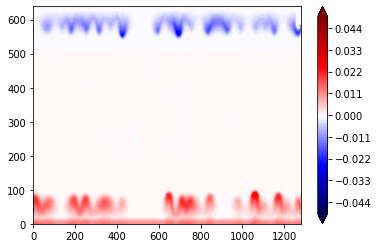

In [ ]:
t=10
plt.figure()
cs=plt.contourf(np.transpose(T[t,:,:]),np.arange(-0.05,0.0501,0.001),cmap='seismic',extend='both')
plt.colorbar(cs)

In [ ]:
f = h5py.File('snapshots/snapshots.h5', 'r')
T = f['tasks']['T']
np.shape(T)
for t in range(0,np.shape(T)[0]):
    fig=plt.figure(figsize=(8.5, 3), dpi=300)
    cs=plt.contourf(xx*100,zz*100,T[t,:,:],np.arange(-0.05,0.05005,0.0005),cmap='seismic',extend='both')
    plt.colorbar(cs)
    fig.savefig('/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/t_'+str(t).zfill(4)+'.png', dpi=150, bbox_inches='tight')
    plt.close(fig) 

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/t_*.png"
fp_out = "/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=10, loop=0)


In [ ]:
!ls /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/image.gif

/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/image.gif


In [ ]:
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    T = file['tasks']['T']
    t = T.dims[0]['sim_time']
    x = T.dims[1][0]
    z = T.dims[2][0]
    print(np.shape(T))

(5000, 128, 64)


In [ ]:
np.array(T[0].T)

ValueError: ignored

In [ ]:
#Analysis 1 
#Convection plotting using temperature 
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    T = file['tasks']['T']
    t = T.dims[0]['sim_time']
    x = T.dims[1][0]
    z = T.dims[2][0]

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(7, 6), dpi=100)
    quad = plt.pcolormesh(x, z, T[0].T, shading='nearest', cmap='coolwarm',vmin=0,vmax=1e-1)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=T[:])
    animation.save('convection.gif',fps=200)



2022-03-21 02:59:21,625 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-03-21 02:59:21,629 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 700x600 -pix_fmt rgba -r 200 -i pipe: -vcodec h264 -pix_fmt yuv420p -y convection.gif
2022-03-21 02:59:21,825 matplotlib.animation 0/1 WARNING :: MovieWriter stderr:
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgs

CalledProcessError: ignored

ValueError: ignored

<Figure size 700x600 with 2 Axes>

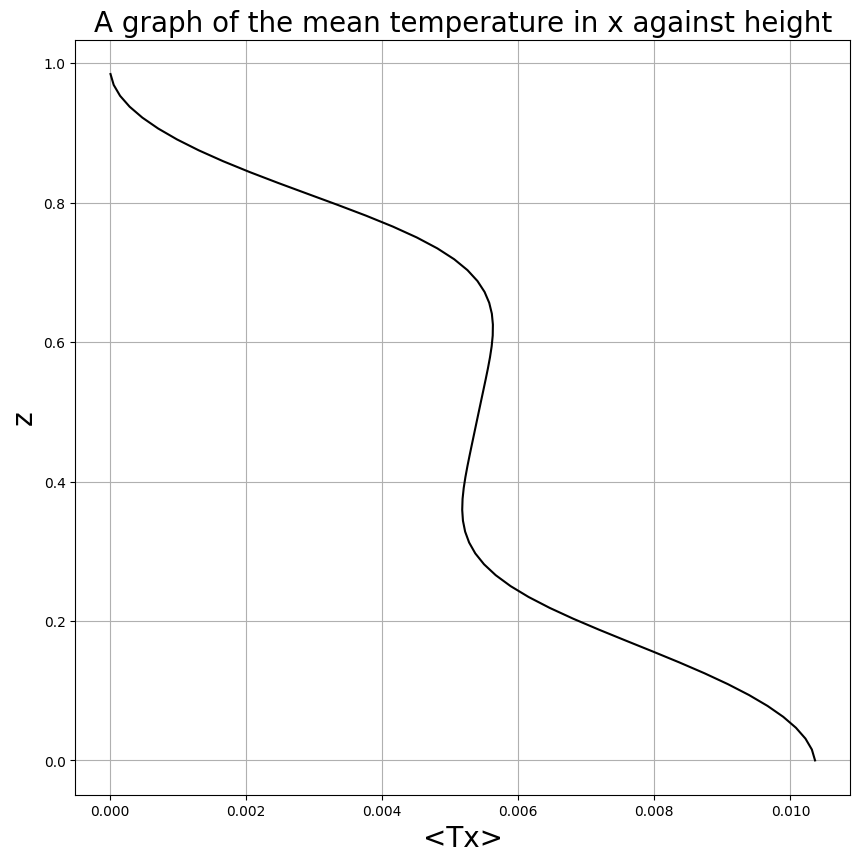

In [ ]:
#Analysis 2
#Plotting average temperature as a function of height
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    #Load analysis datasets:
    Tx = file['tasks']['<Tx>']
    z = np.arange(0.,d,1/zres)
    t = Tx.dims[0]

    #Plot data
    fig = plt.figure(figsize=(10,10), dpi=100)
    quad = plt.plot(Tx[-1][0][:],z,'black')
    plt.title('A graph of the mean temperature in x against height',fontsize=20)
    plt.grid()
    plt.xlabel('<Tx>',fontsize=20)
    plt.ylabel('z',fontsize=20)
    plt.savefig("meantemp.jpeg")

In [ ]:
#Analysis 3
#Convection plotting using kinetic energy
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    KE = file['tasks']['KE']
    t = KE.dims[0]['sim_time']
    x =KE.dims[1][0]
    z = KE.dims[2][0]

    KEmax = np.max(KE[:][:][:])

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(10, 10), dpi=100)
    quad = plt.pcolormesh(x, z, KE[0].T, shading='nearest', cmap='inferno',vmin = 0,vmax=0. 95 * KEmax)
    plt.colorbar(label='Kinetic Energy')
    plt.title('A graph showing the kinetic energy of \na fluid in Rayleigh-Bernard convection through time')
    plt.xlabel('x', fontsize=20)
    plt.ylabel('z', fontsize=20)
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=KE[:])
    animation.save('KEconvection.gif',fps=200)

In [ ]:
#Analysis 4
#Convection plotting using momentum
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    uvec = file['tasks']['|uvec|']
    t = uvec.dims[0]['sim_time']
    x =uvec.dims[1][0]
    z = uvec.dims[2][0]

    uvecmax = np.max(uvec[:][:][:])

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(10, 10), dpi=100)
    quad = plt.pcolormesh(x, z, uvec[0].T, shading='nearest', cmap='inferno', vmin = 0, vmax= 0.95 * uvecmax)
    plt.colorbar(label='|u|')
    plt.title(' ')
    plt.xlabel('x', fontsize=20)
    plt.ylabel('z', fontsize=20)
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=uvec[:])
    animation.save('uvec_convection.gif',fps=200)